In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [2]:
label_to_letter = {
    0: "alpha", 1: "beta", 2: "gamma", 3: "delta", 4: "epsilon",
    5: "eta", 6: "theta", 7: "lambda", 8: "mu", 9: "pi"
}

In [3]:
class GreekCSVData(Dataset):
    def __init__(self, x, t, transform=None):
        self.x = x
        self.t = t
        self.transform = transform

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        img = self.x[idx].reshape(100, 100).astype(np.float32)
        img = torch.from_numpy(img).unsqueeze(0) / 255.0  # Grayscale [1, 100, 100]

        if self.transform:
            img = self.transform(img)

        # Convert label to long tensor
        label = int(self.t[idx])  # Just ensure it’s an int first
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),  # NEW LAYER
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),  # Prevent overfitting
            nn.Linear(9216, 128),  # Update this based on image size
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [16]:
'''
def test(x, t, display_images=5):
    label_letter = {
        0: "alpha",
        1: "beta",
        2: "gamma",
        3: "delta",
        4: "epsilon",
        5: "eta",
        6: "theta",
        7: "lambda",
        8: "mu",
        9: "pi"
    }

    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])
    
    dataset = GreekCSVData(x, t, transform=transform)
    dataLoader = DataLoader(dataset, batch_size=32, shuffle=32)

    model = CNNModel()
    num_ftrs = model.fc.in_fea
    model.fc = torch.nn.Linear
'''

def test(x_path, t_path, display_images=5):
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.Normalize([0.5], [0.5])
    ])

    x = pd.read_csv(x_path, header=None).values
    t = pd.read_csv(t_path, header=None).values.squeeze()
    dataset = GreekCSVData(x, t, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    model = CNNModel()
    model.load_state_dict(torch.load("greek_model.pt", map_location=torch.device('cpu')))
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    incorrect_preds = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    incorrect_preds.append(preds[i].item())
                    incorrect_images.append(imgs[i].cpu().numpy())
                    incorrect_labels.append(labels[i].item())
                    incorrect_predictions.append(preds[i].item())

    accuracy = correct / total
    print(f"✅ Test Accuracy: {accuracy:.4f}")

    # Visualize incorrect predictions
    num_incorrect = min(display_images, len(incorrect_images))
    if num_incorrect > 0:
        print(f"\n📊 Visualizing {num_incorrect} incorrect predictions:")

        cols = 5
        rows = (num_incorrect + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten()

        for i in range(num_incorrect):
            img = incorrect_images[i].squeeze()
            true_letter = label_to_letter[incorrect_labels[i]]
            pred_letter = label_to_letter[incorrect_predictions[i]]
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"True: {true_letter}\nPred: {pred_letter}")
            axes[i].axis('off')

        for i in range(num_incorrect, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("🎯 No incorrect predictions to visualize.")

    return accuracy, incorrect_preds


✅ Test Accuracy: 0.9208

📊 Visualizing 40 incorrect predictions:


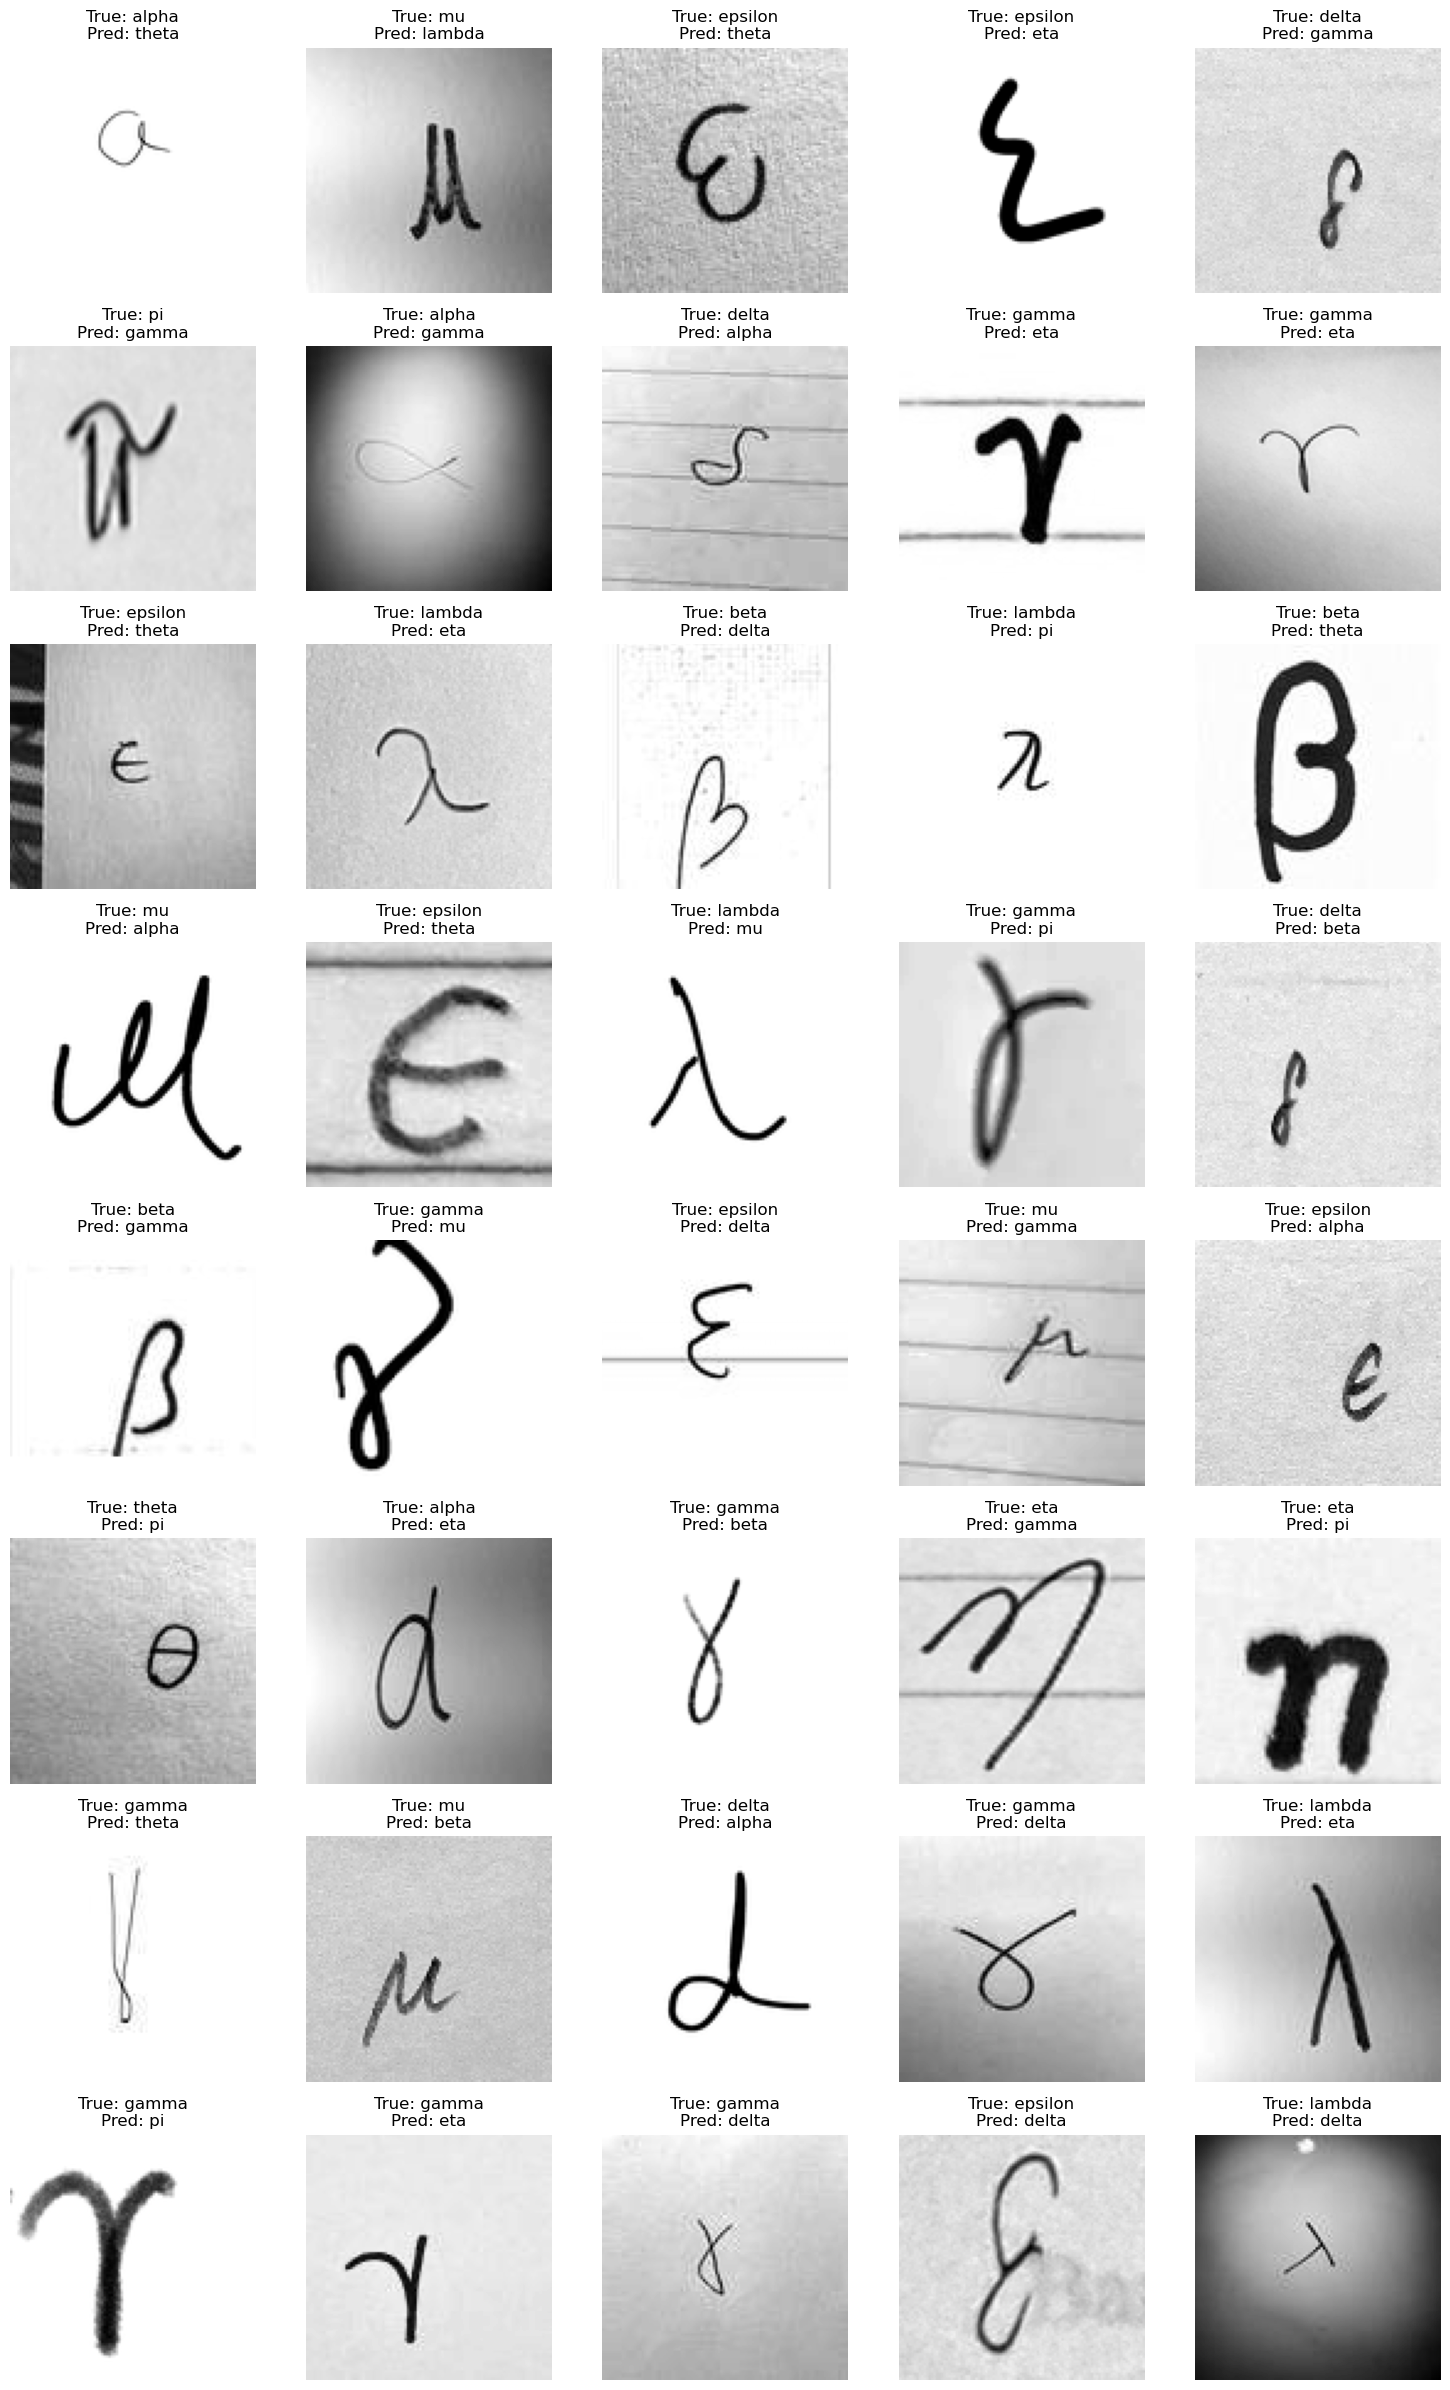

In [20]:
accuracy, incorrect_preds = test('x_test_project.csv', 't_test_project.csv', 40)